# Test on 1-h precipitation reading and daily 12-12UTC accumulation

This notebook is for internal testing only. Several tests have been done in order to envisage an optimal strategy to perform the hourly precipitation accumulation required for FWI.

In [15]:
## Expand JVM memory
options(java.parameters = "-Xmx8000m")

## Internal helpers
source("../R/helpers.R")

## Climate4R
library(loadeR)
library(convertR)


## Check model availability

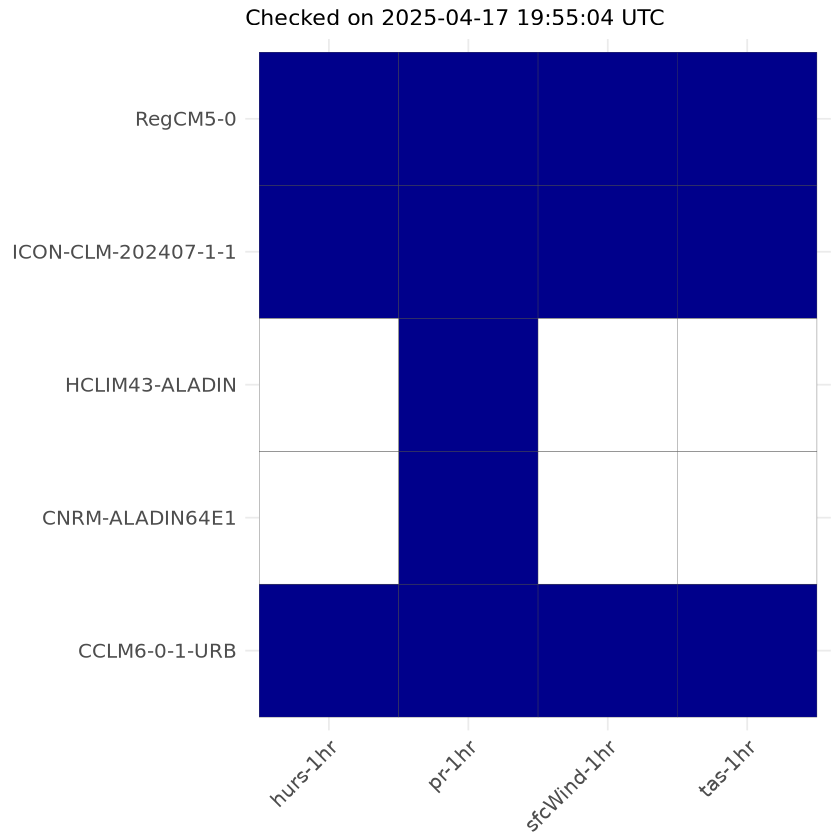

In [2]:
models <- availableModels(do.plot = TRUE)

In [3]:
data.dir <- "/mnt//CORDEX_CMIP6_tmp//sim_data//CORDEX-CMIP6//DD//EUR-12//"

In [4]:
i=1

#for (i in 1:length(models)) {
    model <- models[i]

In [5]:
model

[1] "CCLM6-0-1-URB"

In [6]:
lf <- list.files(data.dir,
                 recursive = TRUE,
                 pattern = paste0("evaluation.*", model, "_.*1hr"),
                 full.names = TRUE) %>% grep("/pr_.*nc$", ., value = TRUE) 
lf[1]

[1] "/mnt//CORDEX_CMIP6_tmp//sim_data//CORDEX-CMIP6//DD//EUR-12///CLMcom-CMCC/ERA5/evaluation/r1i1p1f1/CCLM6-0-1-URB/v1-r1/1hr/pr/v20250201/pr_EUR-12_ERA5_evaluation_r1i1p1f1_CLMcom-CMCC_CCLM6-0-1-URB_v1-r1_1hr_198001010030-198012312330.nc"

In [17]:
## Read just the 2 first files for testing purposes - summer JJA precip
lf <- lf[1:2]
tp.list <- lapply(1:length(lf), function(j) {
    ds <- lf[j]
    message("[", Sys.time(), "] Reading data file ", j, " out of ", length(lf))
    suppressMessages(
        tp <- loadGridData(ds, var = "pr", dictionary = "../dictionary.dic", season = 6:8)
    )
    message("Performing accumulation 12-12")
    tpa <- accum_pr(tp) 
})

[2025-04-17 20:10:04.382745] Reading data file 1 out of 2

Performing accumulation 12-12

[2025-04-17 20:11:38.228474] Reading data file 2 out of 2

Performing accumulation 12-12



In [8]:
print(object.size(tp.list), units = "Mb")

318.5 Mb


Objects are too large... This result suggests that the best choice is performing accumulation on a file-by-file basis, and then aggregating

Just a check of how the time series of accumulated monthly precip (over the entire EUR12 domain) looks like:

In [9]:
test <- do.call("bindGrid", c(tp.list, dimension = "time"))

In [10]:
monthly.pr12 <- aggregateGrid(test, aggr.m = list("sum", na.rm = TRUE))

pad applied on the interval: day



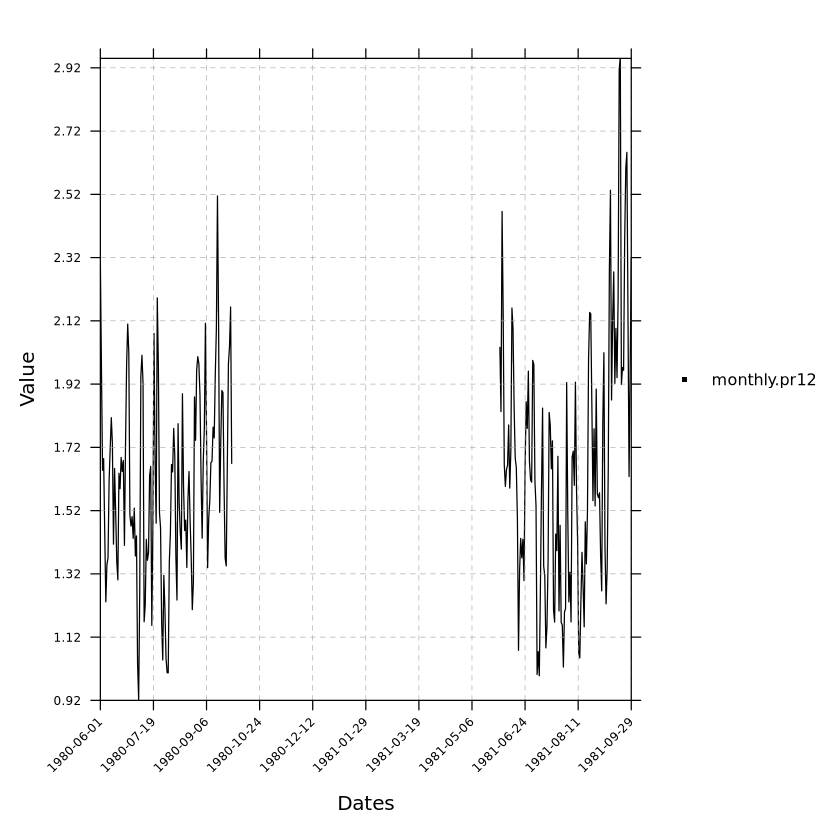

In [13]:
visualizeR::temporalPlot(monthly.pr12)

In [10]:
str(test)


List of 4
 $ Variable:List of 2
  ..$ varName: chr "pr"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi TRUE
  ..- attr(*, "description")= chr "Precipitation"
  ..- attr(*, "units")= chr "mm"
  ..- attr(*, "longname")= chr "total precipitation amount"
  ..- attr(*, "daily_agg_cellfun")= chr "sum"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "12:00 UTC"
 $ Data    : num [1:366, 1:406, 1:418] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 4
  ..$ x  : num [1:418] -28 -27.9 -27.8 -27.7 -27.6 ...
  ..$ y  : num [1:406] -23 -22.9 -22.8 -22.7 -22.6 ...
  ..$ lon: num [1:406, 1:418] -9.9 -9.95 -10 -10.04 -10.09 ...
  ..$ lat: num [1:406, 1:418] 22.4 22.5 22.6 22.7 22.8 ...
  ..- attr(*, "projection")= chr "RotatedPole"
  ..- attr(*, "grid_mapping_name")= chr "rotated_latitude_longitude"
  ..- attr(*, "grid_north_pole_latitude")= chr "39.25"
  ..- attr(*, "grid_north_pole_longitude")= c